In [1]:
import os
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

2023-03-22 00:00:04.930114: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-22 00:00:05.014920: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-03-22 00:00:05.350095: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/ghubro/anaconda3/envs/ml_dev/lib/
2023-03-22 00:00:05.350136: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_pl

In [2]:
# Load data
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [3]:
# Check dimensions of image
x_train[0].shape

(28, 28)

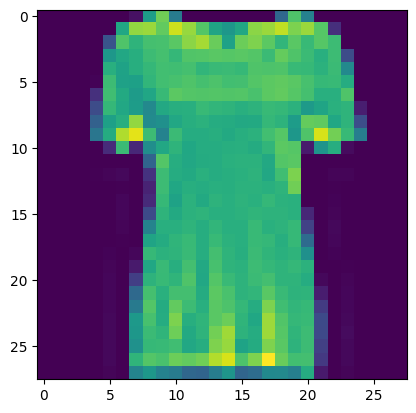

In [4]:
# View a sample image
plt.imshow(x_train[10])

In [5]:
##################################################
# Explore training data and labels
##################################################

In [6]:
x_train

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       ...,

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 

In [7]:
x_train[10].max()

255

In [8]:
y_train

array([9, 0, 0, ..., 3, 0, 5], dtype=uint8)

In [9]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(60000, 28, 28)
Test data shape:(10000, 28, 28)


In [10]:
print("Number of classes training labels:{}".format(len(pd.unique(y_train))))
print("Unique values in training labels:{}".format(pd.unique(y_train)))

Number of classes training labels:10
Unique values in training labels:[9 0 3 2 7 5 1 6 4 8]


In [11]:
# Normalize image pixel values
x_train = x_train / 255
x_test = x_test / 255

In [12]:
# Prepare one-hot encoded y-values
y_train_cat = keras.utils.to_categorical(y=y_train, num_classes=10)
y_test_cat = keras.utils.to_categorical(y=y_test, num_classes=10)

In [13]:
# Reshaping data to batch_size, width, height, color_channel
x_train = x_train.reshape(60000, 28, 28, 1)
x_test = x_test.reshape(10000, 28, 28, 1)

In [14]:
# Prepare GPU
def prep_devices():
    phy_gpus = tf.config.list_physical_devices(device_type='GPU')
    
    for gpu in phy_gpus:
        tf.config.experimental.set_memory_growth(device=gpu, enable=True)

    log_gpus = tf.config.list_logical_devices(device_type='GPU')
    phy_cpus = tf.config.list_physical_devices(device_type='CPU')
    log_cpus = tf.config.list_logical_devices(device_type='CPU')

    print("Physical GPUs: {}\tLogical GPUs: {}\nPhysical CPUs: {}\tLogical CPUs: {}".format(len(phy_gpus),
                                                                                             len(log_gpus),
                                                                                             len(phy_cpus),
                                                                                             len(log_cpus)))

In [15]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
prep_devices()

Physical GPUs: 1	Logical GPUs: 1
Physical CPUs: 1	Logical CPUs: 1


2023-03-22 00:00:33.306276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 00:00:33.308842: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 00:00:33.308965: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-22 00:00:33.309508: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [16]:
# Build model
def model_func(clear_session=True):
    if clear_session:
        backend.clear_session()
            
    model = Sequential()
    
    model.add(Conv2D(filters=32, kernel_size=(2, 2), input_shape=(28, 28, 1), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Dropout(0.5))
    
    model.add(Conv2D(filters=32, kernel_size=(2, 2), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    
    model.summary()
    
    return model

In [17]:
# Fit model
model = model_func()
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)
model.fit(x=x_train, y=y_train_cat, epochs=100, validation_split=0.1, batch_size=500, callbacks=[early_stop])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 27, 27, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 12, 12, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1152)              0

2023-03-22 00:19:46.385297: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169344000 exceeds 10% of free system memory.
2023-03-22 00:19:46.504214: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 169344000 exceeds 10% of free system memory.
2023-03-22 00:19:47.260314: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-03-22 00:19:47.630383: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 00:19:47.630762: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 00:19:47.630772: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-03-22 00:19:47.631161: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-03-22 00:19:47.631193: W

108/108 [==============================] - 2s 6ms/step - loss: 1.1596 - accuracy: 0.5683 - val_loss: 0.6425 - val_accuracy: 0.7603
Epoch 2/100
108/108 [==============================] - 0s 4ms/step - loss: 0.7122 - accuracy: 0.7368 - val_loss: 0.5323 - val_accuracy: 0.7922
Epoch 3/100
108/108 [==============================] - 0s 4ms/step - loss: 0.6256 - accuracy: 0.7697 - val_loss: 0.4947 - val_accuracy: 0.8080
Epoch 4/100
108/108 [==============================] - 0s 4ms/step - loss: 0.5827 - accuracy: 0.7859 - val_loss: 0.4609 - val_accuracy: 0.8235
Epoch 5/100
108/108 [==============================] - 0s 4ms/step - loss: 0.5547 - accuracy: 0.7974 - val_loss: 0.4273 - val_accuracy: 0.8422
Epoch 6/100
108/108 [==============================] - 0s 4ms/step - loss: 0.5371 - accuracy: 0.8045 - val_loss: 0.4057 - val_accuracy: 0.8483
Epoch 7/100
108/108 [==============================] - 0s 4ms/step - loss: 0.5149 - accuracy: 0.8134 - val_loss: 0.3989 - val_accuracy: 0.8558
Epoch 8/100

In [18]:
# Model evaluation
metrics = pd.DataFrame(model.history.history)
metrics

,loss,accuracy,val_loss,val_accuracy
0,1.159647,0.568315,0.642488,0.760333
1,0.712198,0.736796,0.532308,0.792167
2,0.625560,0.769685,0.494651,0.808000
3,0.582699,0.785926,0.460894,0.823500
4,0.554673,0.797444,0.427337,0.842167
...,...,...,...,...
73,0.301326,0.888870,0.241672,0.910167
74,0.298101,0.891167,0.241585,0.911500
75,0.299150,0.890222,0.239927,0.911167
76,0.294641,0.888815,0.238892,0.910667


<Axes: >

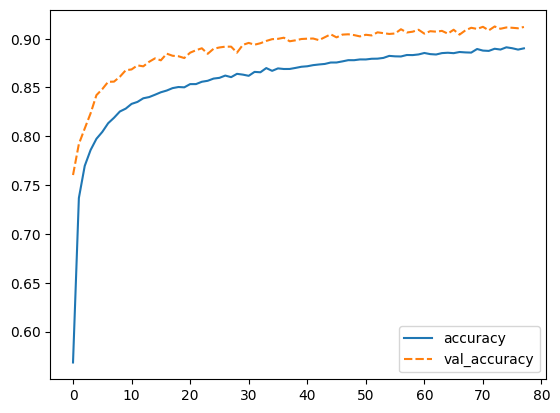

In [19]:
# Evaluate graphically
metrics = pd.DataFrame(model.history.history)
sns.lineplot(data=metrics[['accuracy', 'val_accuracy']])

In [20]:
# Compute predicted classes and model performance metrics
y_pred = np.argmax(model.predict(x_test), axis=-1)

print(classification_report(y_true=y_test, y_pred=y_pred))
print("\n")
print(confusion_matrix(y_true=y_test, y_pred=y_pred))

313/313 [==============================] - 0s 665us/step
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      1000
           1       1.00      0.97      0.98      1000
           2       0.85      0.87      0.86      1000
           3       0.89      0.92      0.90      1000
           4       0.84      0.86      0.85      1000
           5       0.98      0.98      0.98      1000
           6       0.75      0.69      0.72      1000
           7       0.95      0.97      0.96      1000
           8       0.98      0.98      0.98      1000
           9       0.97      0.96      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



[[858   0  20  23   6   0  89   0   4   0]
 [  0 973   1  20   3   0   1   0   2   0]
 [ 15   0 873  10  52   0  49   0   1   0]
 [ 15   2  10 918  25   0  28   0   2   0]
 [  1   1 